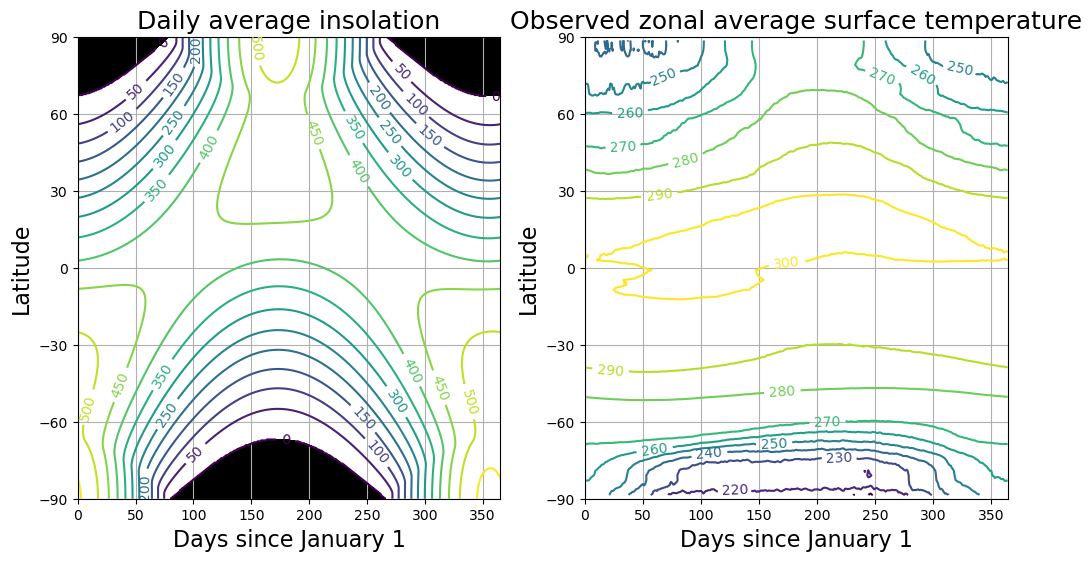

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from climlab import constants as const

#  Calculate daily average insolation as function of latitude and time of year
lat = np.linspace( -90., 90., 500 )
days = np.linspace(0, const.days_per_year, 365 )
Q = climlab.solar.insolation.daily_insolation( lat, days )

##  daily surface temperature from  NCEP reanalysis
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
ncep_temp = xr.open_dataset( ncep_url + "skt.sfc.day.1981-2010.ltm.nc", decode_times=False)
#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/'
#skt_path = 'surface_gauss/skt'
#ncep_temp = xr.open_dataset(url+skt_path)
ncep_temp_zon = ncep_temp.skt.mean(dim='lon')

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
CS = ax1.contour( days, lat, Q , levels = np.arange(0., 600., 50.) )
ax1.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=10)
ax1.set_title('Daily average insolation', fontsize=18 )
ax1.contourf ( days, lat, Q, levels=[-100., 0.], colors='k' )

ax2 = fig.add_subplot(122)
CS = ax2.contour( (ncep_temp.time - ncep_temp.time[0])/const.hours_per_day, ncep_temp.lat, 
                 ncep_temp_zon.T, levels=np.arange(210., 310., 10. ) )
ax2.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=10)
ax2.set_title('Observed zonal average surface temperature', fontsize=18 )

for ax in [ax1,ax2]:
    ax.set_xlabel('Days since January 1', fontsize=16 )
    ax.set_ylabel('Latitude', fontsize=16 )
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    ax.grid()

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (40, 1) 
  Tatm: (40, 30) 
The subprocess tree: 
RCM: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   Fixed Relative Humidity: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>

Integrating for 81 steps, 81.0 days, or 0.22177064972229385 years.


Total elapsed time is 0.22177064972229385 years.
Integrating for 91 steps, 91.99999999999999 days, or 0.2518876515364325 years.


Total elapsed time is 0.4709203920028956 years.
Integrating for 94 steps, 94.00000000000001 days, or 0.2573634700480941 years.


Total elapsed time is 0.7282838620509897 years.
Integrating for 91 steps, 91.0 days, or 0.24914974228060174 years.


Total elapsed time is 0.9774336043315914 years.


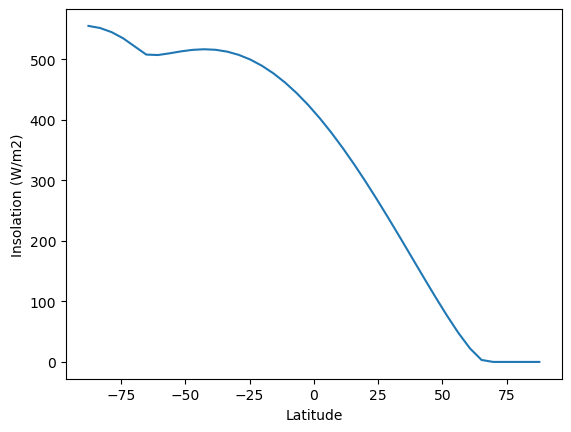

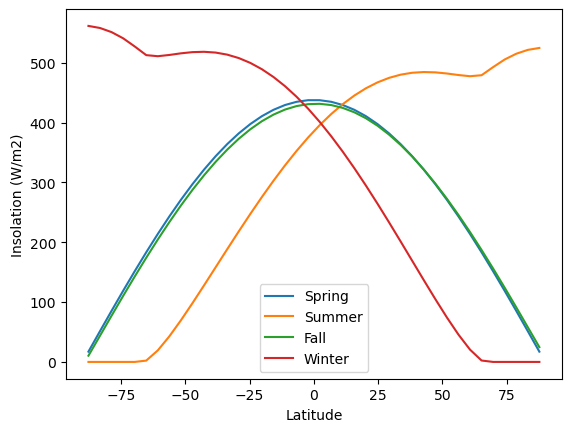

In [2]:
# A two-dimensional domain
state = climlab.column_state(num_lev=30, num_lat=40, water_depth=10.)
#  Specified relative humidity distribution
h2o = climlab.radiation.ManabeWaterVapor(name='Fixed Relative Humidity', state=state)
#  Hard convective adjustment
conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment', state=state, adj_lapse_rate=6.5)
#  Daily insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(name='Insolation', domains=state['Ts'].domain)
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                             state=state, 
                             specific_humidity=h2o.q, 
                             albedo=0.125,
                             coszen=sun.coszen,
                             irradiance_factor=sun.insolation)
model = climlab.couple([rad,sun,h2o,conv], name='RCM')
print( model)

model.compute_diagnostics()

fig, ax = plt.subplots()
ax.plot(model.lat, model.insolation)
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');

#climlab.radiation.DailyInsolation
#climlab.radiation.AnnualMeanInsolation

#  model is initialized on Jan. 1

#  integrate forward just under 1/4 year... should get about to the NH spring equinox
model.integrate_days(31+28+22)
Q_spring = model.insolation.copy()
#  Then forward to NH summer solstice
model.integrate_days(31+30+31)
Q_summer = model.insolation.copy()
#  and on to autumnal equinox
model.integrate_days(30+31+33)
Q_fall = model.insolation.copy()
#  and finally to NH winter solstice
model.integrate_days(30+31+30)
Q_winter = model.insolation.copy()

fig, ax = plt.subplots()
ax.plot(model.lat, Q_spring, label='Spring')
ax.plot(model.lat, Q_summer, label='Summer')
ax.plot(model.lat, Q_fall, label='Fall')
ax.plot(model.lat, Q_winter, label='Winter')
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');
